In [1]:
from IPython.display import clear_output
from lbmpy.session import *
from lbmpy.relaxationrates import relaxation_rate_from_lattice_viscosity

from pystencils.typing import BasicType, TypedSymbol

# Demo: Interpolation Bounce Back Boundaries
In this notebook we present how to use interpolation bounce back boundaries. We will show this on a simple flow around sphere in two dimensions using the linearised bounce back boundary by [Bouzidi et. al.](https://doi.org/10.1063/1.1399290) and the `QuadraticBounceBack` boundary condition by [Geier et. al.](https://www.sciencedirect.com/science/article/pii/S0898122115002126)

The first part of the demo is similar to other demos / tutorials, so we will not go into detail about these parts

In [2]:
stencil = LBStencil(Stencil.D2Q9)
reference_length = 30
maximal_velocity = 0.05
reynolds_number = 500
kinematic_vicosity = (reference_length * maximal_velocity) / reynolds_number

initial_velocity=(maximal_velocity, 0)
omega = relaxation_rate_from_lattice_viscosity(kinematic_vicosity)

In [3]:
domain_size = (400, 150)
dim = len(domain_size)
circle_mid = np.array((40, 75))
circle_rad = 10

In [4]:
dh = ps.create_data_handling(domain_size=domain_size)

src = dh.add_array('pdfs', values_per_cell=len(stencil))
dh.fill(src.name, 0.0, ghost_layers=True)
dst = dh.add_array('pdfs_tmp', values_per_cell=len(stencil))
dh.fill(dst.name, 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=dh.dim)
dh.fill('velField', 0.0, ghost_layers=True)

densityField = dh.add_array('densityField', values_per_cell=1)
dh.fill('densityField', 1.0, ghost_layers=True)

In [5]:
lbm_config = LBMConfig(stencil=stencil, method=Method.CUMULANT, relaxation_rate=omega,
                       compressible=True, output={"velocity": velField, "density": densityField})

method = create_lb_method(lbm_config=lbm_config)

In [6]:
init = pdf_initialization_assignments(method, 1.0, (0.0, 0.0, 0.0), src.center_vector)

ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

In [7]:
lbm_optimisation = LBMOptimisation(symbolic_field=src, symbolic_temporary_field=dst)
update = create_lb_update_rule(lb_method=method,
                               lbm_config=lbm_config,
                               lbm_optimisation=lbm_optimisation)

ast_kernel = ps.create_kernel(update, target=dh.default_target)
kernel = ast_kernel.compile()

In [8]:
def set_sphere(x, y, *_):
    return (x-circle_mid[0])**2 + (y-circle_mid[1])**2 < circle_rad**2

# Interpolation Boundary Conditions implementation details

The most important part of the interpolation bounce back boundary is, that we need to define the distance to the wall for each boundary cell. Thus, we need to provide a Python CallBack function to the boundary that calculates the normalised wall distance `q` for each cell and stores the value in `boundary_data`. The normalised wall distance is defined as:

$$
\begin{align}
q = \frac{|\boldsymbol{x}_{F} - \boldsymbol{x}_{w}|}{|\boldsymbol{x}_{F} - \boldsymbol{x}_{b}|}.
\end{align}
$$

 The variable `boundary_data` is an index vector that every boundary condition holds internally. For simple boundaries it stores the `x`- and `y`- (and `z` in 3D) coordinate to represent a fluid cell that is next to a boundary cell and the lattice direction `dir` to get from the fluid cell to the boundary cell.

In the case of the interpolation boundaries we have an additional value `q` that needs to be stored in each cell. This value needs to be between 0 and 1, otherwise the boundary condition would fall back to a simple bounce back boundary without interpolation.

<center>   
<img src="../img/Boundary.svg" alt="Boundary.svg" width="400" height="400">  
</center>

Two dimensional representation of the boundary nodes with the normalised wall distance `q`. The figure was inspired by [Directional lattice Boltzmann boundary conditions](https://doi.org/10.13097/archive-ouverte/unige:160770). 

The linear Bouzidi boundary condition is implemented using the following equation
$$
\begin{align}
    f_{\bar{i}}^{t + 1}(\boldsymbol{x}_b) = 
\begin{cases}
    \frac{1}{2q} f_{i}(\boldsymbol{x}_F) + \frac{2q-1}{2q} f_{\bar{i}}(\boldsymbol{x}_{F}), & \text{if } q \geq 0.5\\
    2 q f_{i}(\boldsymbol{x}_F) + (1 - 2q) f_{i}(\boldsymbol{x}_{FF}),              & q > 0 \land q < 0.5 \\
    f_{i}(\boldsymbol{x}_F),              & q = -1
\end{cases}
\end{align}
$$

where $f_{\bar{i}}^{t + 1}(\boldsymbol{x}_b)$ is the missing lattice link that will be needed in the next streaming step. Furthermore, $f_{i}(\boldsymbol{x}_F)$ represents the lattice link flowing in wall direction at $\boldsymbol{x}_{F}$, $f_{\bar{i}}(\boldsymbol{x}_{F})$ is the inverse direction at $\boldsymbol{x}_{F}$ and $f_{i}(\boldsymbol{x}_{FF})$ is the lattice link at the next cell.

**The linearised bounce back boundary by [Bouzidi et. al.](https://doi.org/10.1063/1.1399290) needs a second fluid node for the interpolation. This fluid node is not guaranteed to exist. In this case, we implemented a fallback scenario to a simple bounce back scheme with interpolation by setting `q` to -1.**

To overcome this problem, we can use the `QuadraticBounceBack` boundary condition by [Geier et. al.](https://www.sciencedirect.com/science/article/pii/S0898122115002126). It uses the following rule:

$$
\begin{align}
f_{\bar{i}}^{\mathrm{p}}(\boldsymbol{x}_F) &= \frac{f_{\bar{i}}(\boldsymbol{x}_F) - f_{i}(\boldsymbol{x}_F)}{2} + \frac{f_{\bar{i}}(\boldsymbol{x}_F) + f_{i}(\boldsymbol{x}_F)- \omega(f_{\bar{i}}^{\mathrm{eq}}(\boldsymbol{x}_F) + f_{i}^{\mathrm{eq}}(\boldsymbol{x}_F))}{2 - 2\omega} \\
f_{\bar{i}}^{\mathrm{wall}}(\boldsymbol{x}_F) &= (1 - q)f_{\bar{i}}^{\mathrm{p}}(\boldsymbol{x}_F) + q f_{\bar{i}}(\boldsymbol{x}_F) \\
f_{\bar{i}}^{t + 1}(\boldsymbol{x}_b) &= \frac{1}{q+1} f_{\bar{i}}^{\mathrm{wall}}(\boldsymbol{x}_F) + \frac{q}{q+1}f_{i}(\boldsymbol{x}_F)
\end{align}
$$

In this BC the idea is to realise the interpolation with the pre collision PDF value (marked with the subscript p). Since the pre collision PDF value is not available a simple reconstruction needs to be done. This happens via the BGK rule and the relaxation rate for the fluid viscosity. Thus, this boundary condition needs the equilibrium at the wall. However, the equilibrium at the wall can be calculated inplace from the PDFs. Thus, this BC does not need any further information and can be applied in all cases. Furthermore, we have no more branches with the subgrid distance `q`

In [9]:
def init_wall_distance(boundary_data, **_):
    dim = boundary_data.dim
    coords = [coord for coord, _ in zip(['x', 'y', 'z'], range(dim))]

    for cell in boundary_data.index_array:
        direction = np.array(stencil[cell['dir']])
        fluid_cell = np.array(tuple([cell[coord] for coord in coords])) - np.array([0.5] * dim)
        boundary_cell = fluid_cell + direction
        
        f = fluid_cell - circle_mid
        d = (boundary_cell - circle_mid) - f
        
        a = d.dot(d)
        b = 2.0 * ( d.dot(f))
        c = f.dot(f) - circle_rad**2
        
        bb4ac = b * b - ( 4.0 * a * c )
        assert bb4ac > 0
            
        sqrtbb4ac = np.sqrt(bb4ac)
        q = np.min( [( -b + sqrtbb4ac ) / ( 2.0 * a ), ( -b - sqrtbb4ac ) / ( 2.0 * a )] )
        
        assert q > 0 and q < 1
        
        cell['q'] = q

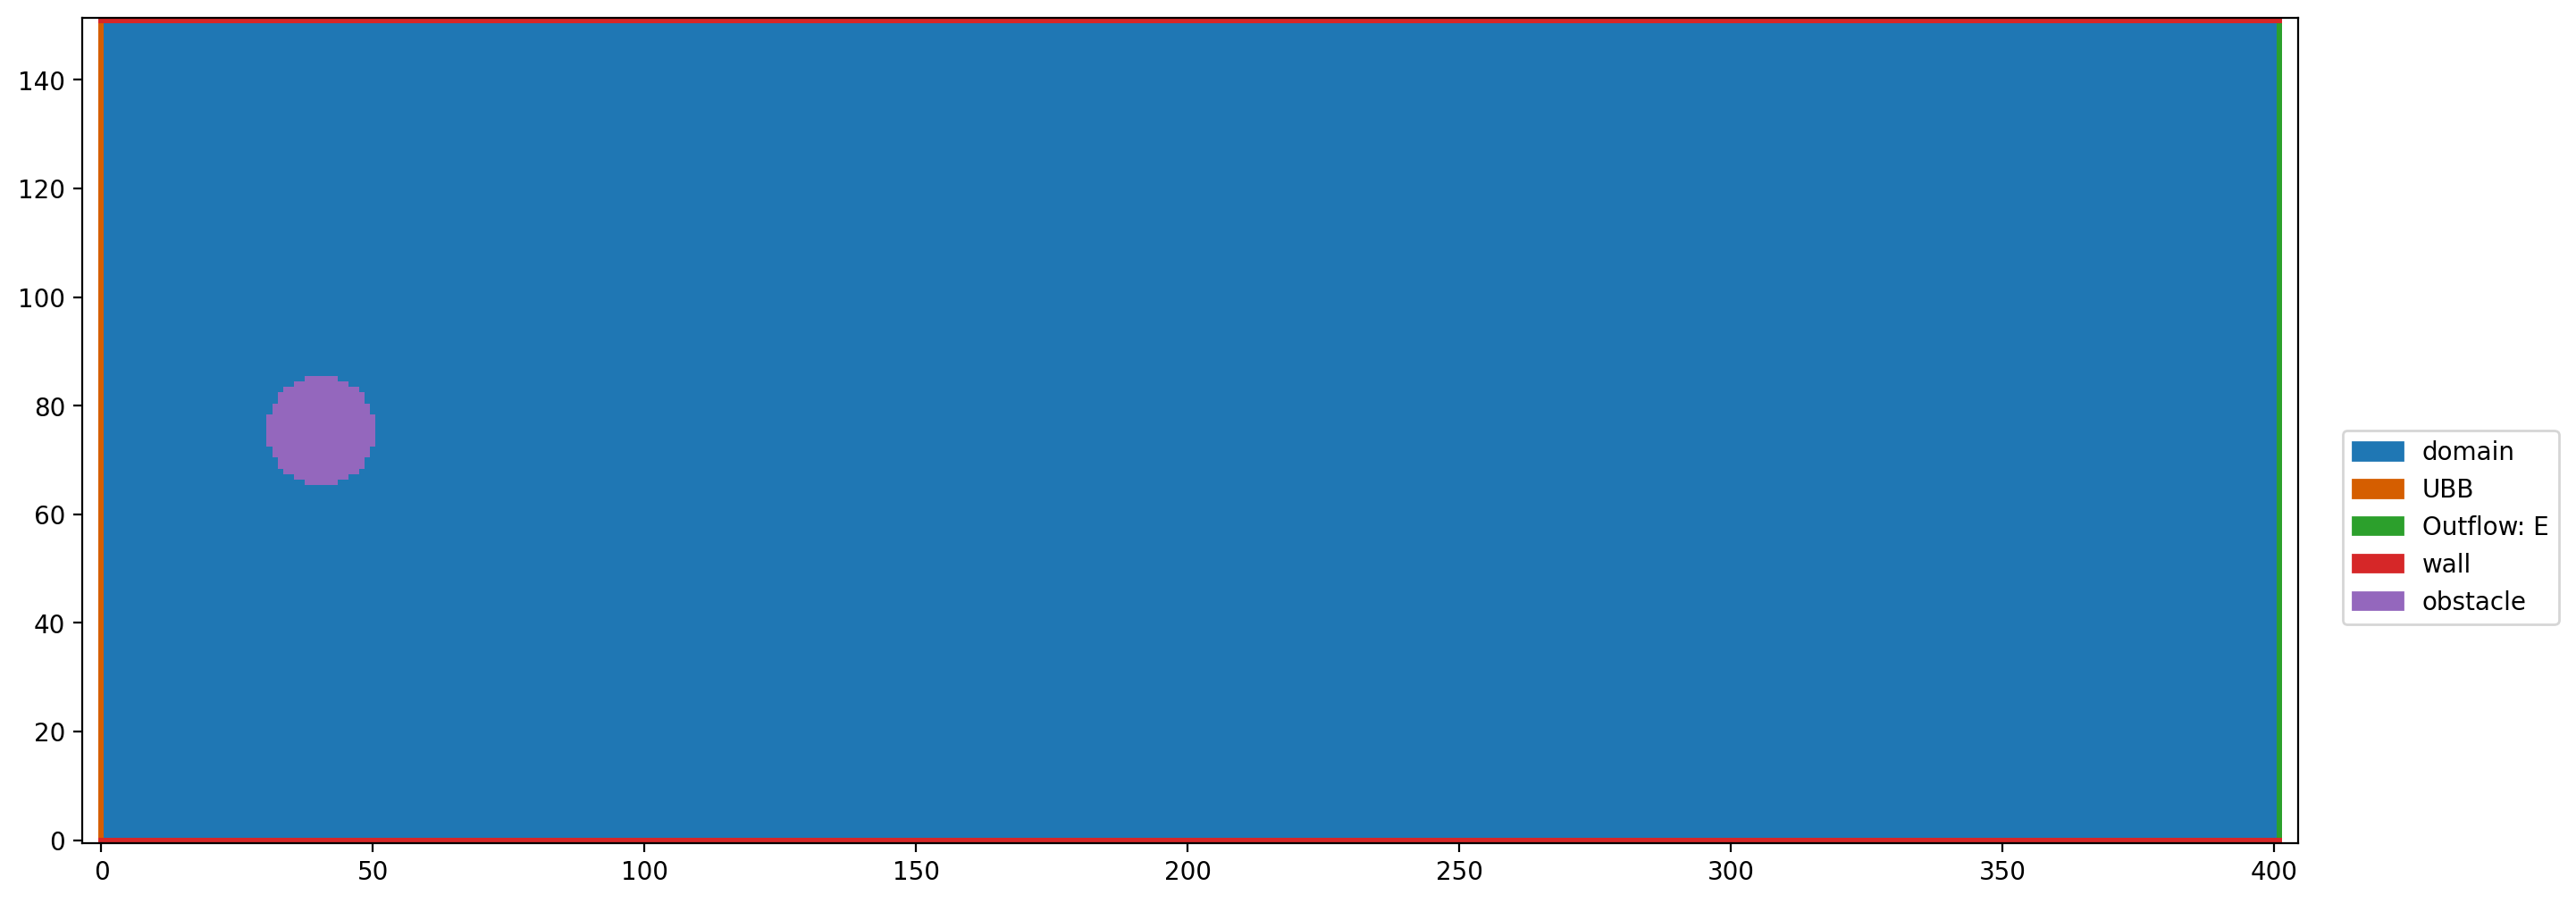

In [10]:
bh = LatticeBoltzmannBoundaryHandling(method, dh, src.name, name="bh")

inflow = UBB(initial_velocity)
outflow = ExtrapolationOutflow(stencil[4], method)
wall = NoSlip("wall")
# obstacle = NoSlip("obstacle")
# obstacle = NoSlipLinearBouzidi("obstacle", init_wall_distance=init_wall_distance)
obstacle = QuadraticBounceBack(omega, "obstacle", init_wall_distance=init_wall_distance)

bh.set_boundary(inflow, slice_from_direction('W', dim))
bh.set_boundary(outflow, slice_from_direction('E', dim))
for direction in ('N', 'S'):
    bh.set_boundary(wall, slice_from_direction(direction, dim))

bh.set_boundary(obstacle, mask_callback=set_sphere)

plt.figure(dpi=200)
plt.boundary_handling(bh)

In [11]:
def timeloop(timeSteps):
    for i in range(timeSteps):
        bh()
        dh.run_kernel(kernel)
        dh.swap(src.name, dst.name)

In [12]:
mask = np.fromfunction(set_sphere, (domain_size[0], domain_size[1], len(domain_size)))
if 'is_test_run' not in globals():
    timeloop(50000)  # initial steps

    def run():
        timeloop(50)
        return np.ma.array(dh.gather_array('velField'), mask=mask)

    animation = plt.vector_field_magnitude_animation(run, frames=600, rescale=True)
    set_display_mode('video')
    res = display_animation(animation)
else:
    timeloop(10)
    res = None
res